# Mask2Face
This notebook will guide you through all the steps described in this article to build and train your ML model for removing the face mask of the person's face.

In [1]:
# Necessary imports
import os
import tarfile
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import download_data
from utils.configuration import Configuration
from utils.data_generator import DataGenerator
from utils.architectures import UNet
from utils.model import Mask2FaceModel

Num GPUs Available:  1
Num CPUs Available:  1


In [ ]:
# setup HW

# is GPU available
gpu_physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_physical_devices) > 0:
    tf.config.experimental.set_memory_growth(gpu_physical_devices[0], True)

# check HW availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

## 1) Preconditions
First we need a dataset of human faces.

In [2]:
# Check if dataset is already downloaded or needs to be downloaded.
configuration = Configuration()
dataset_path = configuration.get('input_images_path')
if os.path.isdir(dataset_path):
    print('Dataset already downloaded')
else:
    print('Downloading dataset')
    dataset_archive_path = os.path.join('data', 'lfw-deepfunneled.tgz')
    download_data(configuration.get('dataset_archive_download_url'), dataset_archive_path)
    print('Extracting dataset')
    tar = tarfile.open(dataset_archive_path, 'r:gz')
    tar.extractall('data')
    tar.close()
    print('Done')

Dataset already downloaded


## 2) Data generation
Next step is to generate data for neural network training. We need input images (person with a face mask) and corresponding output image (the same image as input but without the face mask). We already have output images in downloaded dataset. Input images will be created by adding mask on the faces with a help from [MaskTheFace GitHub](https://github.com/aqeelanwar/MaskTheFace) project.

Testing and training data already generated
Here are few examples of generated data.


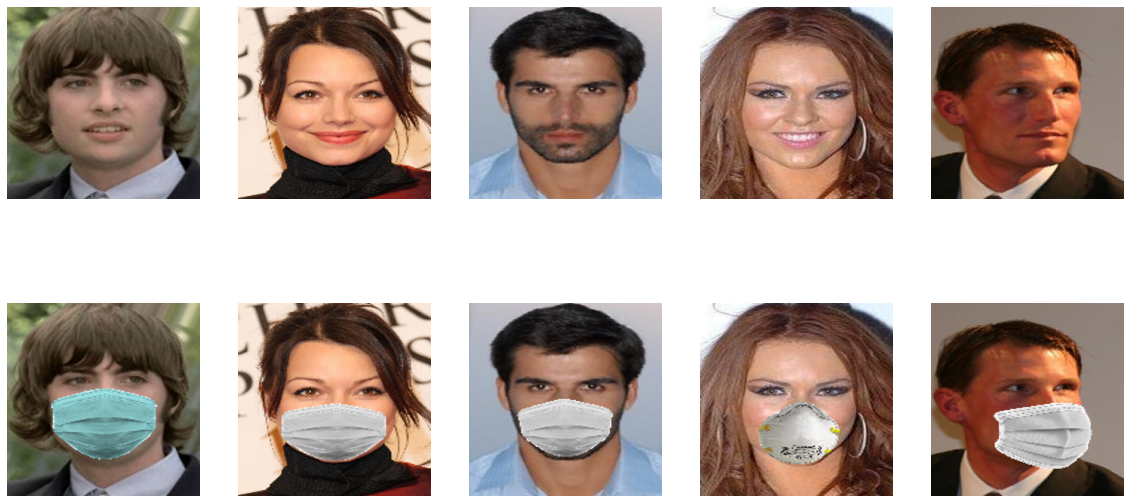

In [3]:
# setup the pipeline and generate data

dg = DataGenerator(configuration)

train_folder = configuration.get('train_data_path')
test_folder = configuration.get('test_data_path')

if os.path.exists(train_folder) and os.path.exists(test_folder):
    print('Testing and training data already generated')
else:
    dg.generate_images()

print('Here are few examples of generated data.')
n_examples = 5
inputs, outputs = dg.get_dataset_examples(n_examples)
f, axarr = plt.subplots(2, n_examples, figsize=(20, 10))
for i in range(len(inputs)):
    axarr[1, i].imshow(mpimg.imread(inputs[i]))
    axarr[1, i].axis('off')
    axarr[0, i].imshow(mpimg.imread(outputs[i]))
    axarr[0, i].axis('off')

## 3) Model training
Now we have all the data, and we can initiate model and start training.

In [5]:
# Feel free to experiment with the number of filters, their sizes or any other parameters
filters = (64, 128, 128, 256, 256, 512)
kernels = (7, 7, 7, 3, 3, 3)
input_image_size = (256, 256, 3)
architecture = UNet.RESNET
training_epochs = 20
batch_size = 12

In [21]:
# Create instance of model and start training
model = Mask2FaceModel.build_model(architecture=architecture, input_size=input_image_size, filters=filters,
                                   kernels=kernels, configuration=configuration)
model.train(epochs=training_epochs, batch_size=batch_size, loss_function='ssim_l1_loss')

# If you already have pretrained model you can uncomment next line and load it instead of training new one
# model = Mask2FaceModel.load_model('path_to_your_trained_model.h5')

## 4) Results
Our model is trained, and we can look at it's performance

Outputs generated on previously unseen data.


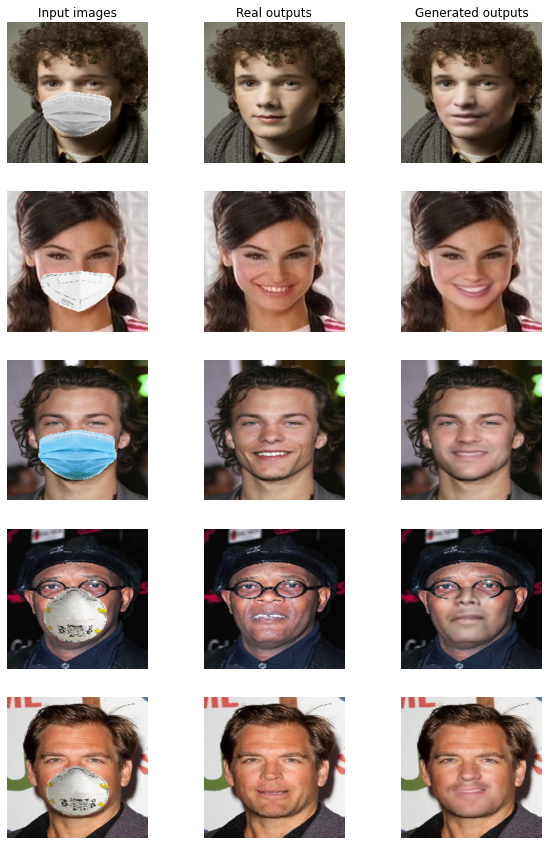

In [25]:
# Let's see the results on a random testing image unseen by the model before.
# Run this cell multiple times to see different results
n_examples = 3
input_imgs, true_output_imgs = dg.get_dataset_examples(n_examples, test_dataset=False)
f, axarr = plt.subplots(n_examples, 3, figsize=(10, n_examples * 3))
for i, img in enumerate(input_imgs):
    generated_output = model.predict(img)
    axarr[i, 0].imshow(mpimg.imread(input_imgs[i]))
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(mpimg.imread(true_output_imgs[i]))
    axarr[i, 1].axis('off')
    axarr[i, 2].imshow(generated_output)
    axarr[i, 2].axis('off')

axarr[0, 0].set_title('Input images')
axarr[0, 1].set_title('Real outputs')
axarr[0, 2].set_title('Generated outputs')
print('Outputs generated on previously unseen data.')